In [ ]:
import sys
import os
import time
import numpy as np
import pinocchio as pin

# Add the bsqp interface to path
sys.path.append('./python/bsqp')
sys.path.append('./python')
from bsqp.interface import BSQP
from force_estimator import ImprovedForceEstimator

np.set_printoptions(linewidth=99999999)
np.random.seed(42)


class MPC_GATO:
    def __init__(self, model, N, dt, batch_size):
        # Store original model for solver (without pendulum)
        self.solver_model = model
        
        # Create augmented model for simulation (with pendulum)
        self.model = self.add_pendulum_to_model(model.copy())
        self.model.gravity.linear = np.array([0, 0, -9.81])
        self.data = self.model.createData()
        
        # Initialize BSQP solver with original model (no pendulum)
        self.solver = BSQP(
            model_path="indy7-mpc/description/indy7.urdf",
            batch_size=batch_size,
            N=N,
            dt=dt,
            max_sqp_iters=4,
            kkt_tol=1e-4,
            max_pcg_iters=100,
            pcg_tol=1e-6,
            solve_ratio=1.0,
            mu=10.0,
            q_cost=2.0,
            qd_cost=1e-2,
            u_cost=4e-7,
            N_cost=100.0,
            q_lim_cost=0.00,
            rho=0.01 
        )
        self.q_traj = []  # trajectory for visualization (robot only)
        self.q_traj_full = []  # full trajectory including pendulum
        
        # Dimensions - note model has extra DOFs from pendulum
        self.nq_robot = self.solver_model.nq
        self.nv_robot = self.solver_model.nv
        self.nq = self.model.nq  # Robot + pendulum
        self.nv = self.model.nv  # Robot + pendulum
        self.nx = self.nq_robot + self.nv_robot  # Solver state dimension (robot only)
        self.nu = self.solver_model.nv  # Control dimension (robot only)
        self.N = N
        self.dt = dt
        self.batch_size = batch_size
        

        if batch_size > 1:
            self.force_estimator = ImprovedForceEstimator(
                batch_size=batch_size,
                initial_radius=5.0,  
                min_radius=2.0,      
                max_radius=20.0,     
                smoothing_factor=0.5 
            )
            self.current_force_batch = None
        else:
            self.force_estimator = None
            self.current_force_batch = None
        
        self.actual_f_ext = pin.StdVec_Force()
        for _ in range(self.model.njoints):
            self.actual_f_ext.append(pin.Force.Zero())
    
    def add_pendulum_to_model(self, model):
        """Add a 3D pendulum (spherical joint) to the end-effector."""
        # Get end-effector joint
        ee_joint_id = model.njoints - 1  # Last joint is EE
        
        # Add spherical joint for pendulum
        pendulum_joint_id = model.addJoint(
            ee_joint_id,
            pin.JointModelSpherical(),
            pin.SE3.Identity(),
            "pendulum_joint"
        )
        
        # Pendulum parameters
        mass = 10.0  # kg
        length = 0.6  # m
        
        # Create inertia for pendulum bob (point mass at distance)
        com = np.array([0.0, 0.0, -length])  # Center of mass along -Z
        # For a point mass at distance L: Ixx = Iyy = m*L^2, Izz ≈ 0
        inertia_matrix = np.diag([0.001, 0.001, 0.001])  # Small inertia at COM
        # Create inertia using the constructor
        pendulum_inertia = pin.Inertia(mass, com, inertia_matrix)
        
        # Add pendulum body
        model.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())
        
        return model
    
    def transform_force_to_gato_frame(self, q, f_world):
        """
        Transform a force from world frame at end-effector to local frame at joint 5.
        Uses only robot joints (first nq_robot elements of q).
        """
        # Create data for solver model to do kinematics
        solver_data = self.solver_model.createData()
        
        # Use only robot configuration
        q_robot = q[:self.nq_robot]
        
        # Update kinematics on solver model
        pin.forwardKinematics(self.solver_model, solver_data, q_robot)
        pin.updateFramePlacements(self.solver_model, solver_data)
        
        # Joint indices
        jid_5_pin = 6  # Joint 5 in GATO = Joint 6 in Pinocchio
        jid_ee_pin = self.solver_model.njoints - 1  # End-effector
        
        # Get transformations
        transform_world_to_j5 = solver_data.oMi[jid_5_pin]
        transform_world_to_ee = solver_data.oMi[jid_ee_pin]
        
        # Compute transformation from Joint 5 to End-Effector
        transform_j5_to_ee = transform_world_to_j5.inverse() * transform_world_to_ee
        
        # Create force at end-effector in world frame
        force_ee_world = pin.Force(f_world[:3], f_world[3:])
        
        # Transform to Joint 5 local frame
        force_ee_local = transform_world_to_ee.actInv(force_ee_world)
        wrench_j5_local = transform_j5_to_ee.actInv(force_ee_local)
        
        result = np.zeros(6)
        result[:3] = wrench_j5_local.linear
        result[3:] = wrench_j5_local.angular
        
        return result
    
    def update_force_batch(self, q):
        # No external force hypothesis for single batch
        if self.batch_size == 1:  
            return
        
        self.current_force_batch = self.force_estimator.generate_batch()
        # Transform each force hypothesis to GATO frame
        transformed_batch = np.zeros_like(self.current_force_batch)
        for i in range(self.batch_size):
            # Each hypothesis is in world frame, transform to GATO frame
            transformed_batch[i, :] = self.transform_force_to_gato_frame(q, self.current_force_batch[i, :])
        
        self.solver.set_f_ext_B(transformed_batch)
    
    def evaluate_best_trajectory(self, x_last, u_last, x_curr, dt):
        """Evaluate which trajectory best matches reality (called post-solve)."""
        if self.batch_size == 1:
            return 0
        
        # Simulate all hypotheses with their corresponding forces
        x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
        
        # Calculate errors for all hypotheses
        errors = np.linalg.norm(x_next_batch - x_curr[None, :], axis=1)
        best_id = np.argmin(errors)
        
        # Update estimator with results
        self.force_estimator.update(best_id, errors, alpha=0.4, beta=0.5)
        
        return best_id
                
    def run_mpc(self, x_start, goals, sim_dt=0.001, sim_time=5):        
            
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'ee_goal': [],
            'ee_actual': [],  # Actual end-effector positions
            'ee_velocity': [],  # End-effector velocities
            'controls': [],  # Control inputs (torques)
            'joint_positions': [],  # All joint positions
            'joint_velocities': [],  # All joint velocities
            'timestamps': [],  # Time stamps for each step
            'sqp_iters': [],  # SQP iterations
            'pcg_iters': [],  # PCG iterations
            'force_estimates': [],  # Force estimates (if batch)
            'force_estimates_gato': [],  # Force estimates in GATO frame
            'force_radius': [],  # Force estimator search radius
            'force_confidence': [],  # Force estimator confidence
            'best_trajectory_id': []  # Which trajectory was selected
        }
        
        stats['goal_outcomes_by_idx'] = ['not_reached'] * len(goals)
        
        total_sim_time = 0.0
        steps = 0
        accumulated_time = 0.0
        
        # Initialize augmented state with pendulum at rest
        x_start_aug = np.zeros(self.nq + self.nv)
        x_start_aug[:self.nx] = x_start  # Robot state
        # Pendulum starts with small initial angle
        x_start_aug[self.nq_robot:self.nq_robot+3] = np.array([0.3, 0.0, 0.0])  # Small rotation
        
        q = x_start_aug[:self.nq]
        dq = x_start_aug[self.nq:]
        
        # Solver uses robot-only state
        x_curr = x_start
        x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
        
        # Initialize first goal
        current_goal_idx = 0
        current_goal = goals[current_goal_idx]
        ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
        ee_g_batch = np.tile(ee_g, (self.batch_size, 1))
        
        XU = np.zeros(self.N*(self.nx+self.nu)-self.nu)
        for i in range(self.N):
            start_idx = i * (self.nx + self.nu)
            XU[start_idx:start_idx+self.nx] = x_curr
        self.solver.reset_dual()
        XU_batch = np.tile(XU, (self.batch_size, 1))
        
        # Warm up run with initial force batch
        self.update_force_batch(q)
        solve_start = time.time()
        XU_batch, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
        solve_time = time.time() - solve_start
        XU_best = XU_batch[0, :]
        
        print(f"\n========== Running MPC for {sim_time} seconds with N={self.N} and batch size={self.batch_size} ==========")
        
        # Start timing for the current goal
        goal_start_time = total_sim_time
                
        while total_sim_time < sim_time:
            steps += 1
            
            timestep = solve_time
            
            x_last = x_curr
            u_last = XU_best[self.nx:self.nx+self.nu]
            
            # ----- Step Simulation -----
            
            nsteps = int(timestep/sim_dt)
            for i in range(nsteps):
                offset = int(i/(self.dt/sim_dt))  # get correct control input
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                
                # Augment control with zero torques for pendulum
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q[:self.nq_robot])  # Store only robot joints
                self.q_traj_full.append(q.copy())  # Store full state
                
            if timestep%sim_dt > 1e-5: 
                accumulated_time += timestep%sim_dt
                
            if accumulated_time - sim_dt > 0.0:
                accumulated_time = 0.0
                
                offset = int(nsteps/(self.dt/sim_dt))
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                
                # Augment control with zero torques for pendulum
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q[:self.nq_robot])  # Store only robot joints
                self.q_traj_full.append(q.copy())  # Store full state
                
            # Update solver state (robot only)
            x_curr = np.concatenate([q[:self.nq_robot], dq[:self.nv_robot]])
            
            # ----- Optimize trajectory toward current goal -----
            
            current_dist = np.linalg.norm(self.eepos(q[:self.nq_robot]) - current_goal)
            current_vel = np.linalg.norm(dq[:self.nv_robot], ord=1)
            reached = (current_dist < 5e-2) and (current_vel < 1.0)
            timeout = (total_sim_time - goal_start_time) >= 4.0
            if reached or timeout:
                if reached:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'reached'
                    print(f"REACHED Goal {current_goal_idx} at {total_sim_time:4.3f}s")
                else:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'timeout'
                    print(f"TIMEOUT Goal {current_goal_idx} at {total_sim_time:4.3f}s")
                current_goal_idx += 1
                if current_goal_idx >= len(goals):
                    print("All goals processed")
                    break
                current_goal = goals[current_goal_idx]
                ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
                goal_start_time = total_sim_time
            
            x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
            ee_g_batch[:, :] = ee_g
            XU_batch[:, :self.nx] = x_curr
            
            self.update_force_batch(q)
            
            solve_start = time.time()
            XU_batch_new, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
            solve_time = time.time() - solve_start
            
            best_id = self.evaluate_best_trajectory(x_last, u_last, x_curr, sim_dt)

            XU_best = XU_batch_new[best_id, :]
            XU_batch[:, :] = XU_best
            # -----
            
            ee_pos = self.eepos(q[:self.nq_robot])
            pin.forwardKinematics(self.solver_model, self.solver_model.createData(), q[:self.nq_robot], dq[:self.nv_robot])
            ee_vel = pin.getFrameVelocity(self.solver_model, self.solver_model.createData(), 6, pin.LOCAL_WORLD_ALIGNED).linear
            
            stats['timestamps'].append(total_sim_time)
            stats['solve_times'].append(float(round(gpu_solve_time/1e3, 5)))
            goaldist = np.sqrt(np.sum((ee_pos[:3] - current_goal)**2))
            stats['goal_distances'].append(float(round(goaldist, 5)))
            stats['ee_goal'].append(current_goal.copy())
            stats['ee_actual'].append(ee_pos.copy())
            stats['ee_velocity'].append(ee_vel.copy())
            stats['controls'].append(u_last.copy())
            stats['joint_positions'].append(q[:self.nq_robot].copy())
            stats['joint_velocities'].append(dq[:self.nv_robot].copy())
            stats['best_trajectory_id'].append(best_id)
            
            # Get solver statistics
            solver_stats = self.solver.get_stats()
            
            stats['sqp_iters'].append(solver_stats['sqp_iters'])
            stats['pcg_iters'].append(solver_stats['pcg_iters'][0] if len(solver_stats['pcg_iters']) > 0 else 0)

            # Calculate actual pendulum force reaction for comparison
            pendulum_com_acc = pin.getFrameClassicalAcceleration(self.model, self.data, self.model.njoints-1, pin.LOCAL_WORLD_ALIGNED).linear
            pendulum_mass = 8.0
            pendulum_force = -pendulum_mass * (pendulum_com_acc - self.model.gravity.linear)
        
            stats['force_estimates'].append(np.concatenate([pendulum_force, np.zeros(3)]))
        
            if steps % 512 == 0:
                # Also print force estimate for monitoring
                if self.force_estimator:
                    est_stats = self.force_estimator.get_stats()
                    smoothed = est_stats['current_estimate']
                    smoothed = self.transform_force_to_gato_frame(q, smoothed)
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | id={best_id} | f_world=[{smoothed[0]:5.1f}, {smoothed[1]:5.1f}, {smoothed[2]:5.1f}] | f_p=[{pendulum_force[0]:5.1f}, {pendulum_force[1]:5.1f}, {pendulum_force[2]:5.1f}] | t={total_sim_time:4.3f}s")
                else:
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | id={best_id} | t={total_sim_time:4.3f}s")

        print(f"avg err: {np.mean(stats['goal_distances']):4.3f}")
        print(f"avg t_sqp: {np.mean(stats['solve_times']):4.3f}ms")
        print(f"========== MPC finished ==========")
        
        # Convert lists to numpy arrays for easier processing
        for key in stats:
            if stats[key]:
                stats[key] = np.array(stats[key])

        return self.q_traj, stats
    
    def rk4(self, q, dq, u, dt):
        k1q = dq
        k1v = pin.aba(self.model, self.data, q, dq, u, self.actual_f_ext)
        q2 = pin.integrate(self.model, q, k1q * dt / 2)
        k2q = dq + k1v * dt/2
        k2v = pin.aba(self.model, self.data, q2, k2q, u, self.actual_f_ext)
        q3 = pin.integrate(self.model, q, k2q * dt / 2)
        k3q = dq + k2v * dt/2
        k3v = pin.aba(self.model, self.data, q3, k3q, u, self.actual_f_ext)
        q4 = pin.integrate(self.model, q, k3q * dt)
        k4q = dq + k3v * dt
        k4v = pin.aba(self.model, self.data, q4, k4q, u, self.actual_f_ext)
        dq_next = dq + (dt/6) * (k1v + 2*k2v + 2*k3v + k4v)
        avg_dq = (k1q + 2*k2q + 2*k3q + k4q) / 6
        q_next = pin.integrate(self.model, q, avg_dq * dt)
        return q_next, dq_next
            
    def eepos(self, q):
        """Get end-effector position using solver model (robot only)."""
        solver_data = self.solver_model.createData()
        pin.forwardKinematics(self.solver_model, solver_data, q)
        return solver_data.oMi[6].translation

In [2]:
goals = [
        np.array([0.5, -.1865, 0.5]),
        np.array([0.5, 0.3, 0.2]),
        np.array([0.3, 0.3, 0.8]),
        np.array([0.6, -0.5, 0.2]),
        np.array([0., -0.5, 0.8])
]

urdf_path = "indy7-mpc/description/indy7.urdf"
model_dir = "indy7-mpc/description/"

model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

N = 16
dt = 0.01

x_start = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

total_time = len(goals) * 5.0



mpc_1 = MPC_GATO(model, N=N, dt=dt, batch_size=1)
q_trajectory, mpc_stats_1 = mpc_1.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

# mpc_4 = MPC_GATO(model, N=N, dt=dt, batch_size=4)
# q_trajectory_4, mpc_stats_4 = mpc_4.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

mpc_8 = MPC_GATO(model, N=N, dt=dt, batch_size=8)
q_trajectory_8, mpc_stats_8 = mpc_8.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

mpc_16 = MPC_GATO(model, N=N, dt=dt, batch_size=16)
q_trajectory_16, mpc_stats_16 = mpc_16.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

mpc_32 = MPC_GATO(model, N=N, dt=dt, batch_size=32)
q_trajectory_32, mpc_stats_32 = mpc_32.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

mpc_64 = MPC_GATO(model, N=N, dt=dt, batch_size=64)
q_trajectory_64, mpc_stats_64 = mpc_64.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

mpc_128 = MPC_GATO(model, N=N, dt=dt, batch_size=128)
q_trajectory_128, mpc_stats_128 = mpc_128.run_mpc(x_start, goals, sim_dt=0.001, sim_time=total_time)

Total L2 cache size: 73728 kB
Setting persisting L2 size to: 50688 / 50688 kB
T : f

========== Running MPC for 25.0 seconds with N=16 and batch size=1 ==========
err=0.656 | qd=15.642 | t_sqp=0.350 ms | id=0 | t=0.126s
err=0.429 | qd=8.161 | t_sqp=0.088 ms | id=0 | t=0.237s
err=0.342 | qd=13.410 | t_sqp=0.235 ms | id=0 | t=0.353s
err=0.366 | qd=40.960 | t_sqp=0.219 ms | id=0 | t=0.479s
err=0.367 | qd=5.376 | t_sqp=0.088 ms | id=0 | t=0.577s
err=0.256 | qd=3.206 | t_sqp=0.095 ms | id=0 | t=0.674s
err=0.197 | qd=2.924 | t_sqp=0.096 ms | id=0 | t=0.756s
err=0.160 | qd=2.663 | t_sqp=0.095 ms | id=0 | t=0.839s
err=0.132 | qd=2.310 | t_sqp=0.200 ms | id=0 | t=0.921s
err=0.109 | qd=2.422 | t_sqp=0.088 ms | id=0 | t=1.002s
err=0.094 | qd=2.227 | t_sqp=0.094 ms | id=0 | t=1.074s
err=0.086 | qd=2.411 | t_sqp=0.094 ms | id=0 | t=1.144s
err=0.086 | qd=2.400 | t_sqp=0.095 ms | id=0 | t=1.217s
err=0.094 | qd=2.277 | t_sqp=0.228 ms | id=0 | t=1.292s
err=0.109 | qd=2.847 | t_sqp=0.211 ms | id=0 | t=1

In [ ]:
import meshcat.geometry as g
import meshcat.transformations as tf
from pinocchio.visualize import MeshcatVisualizer
import numpy as np
import pinocchio as pin
import time

# Build models for visualization
urdf_path = "indy7-mpc/description/indy7.urdf"
model_dir = "indy7-mpc/description"
model_viz, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

# Add pendulum to visualization model
ee_joint_id = model_viz.njoints - 1
pendulum_joint_id = model_viz.addJoint(
    ee_joint_id,
    pin.JointModelSpherical(),
    pin.SE3.Identity(),
    "pendulum_joint"
)
mass = 10.0
length = 0.6
com = np.array([0.0, 0.0, -length])
inertia_matrix = np.diag([0.001, 0.001, 0.001])
pendulum_inertia = pin.Inertia(mass, com, inertia_matrix)
model_viz.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())

viz = MeshcatVisualizer(model_viz, collision_model, visual_model)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot")


# Pendulum rod
viz.viewer['pendulum_rod'].set_object(
    g.Cylinder(height=length, radius=0.01),
    g.MeshLambertMaterial(color=0x808080)
)

# Pendulum bob
viz.viewer['pendulum_bob'].set_object(
    g.Sphere(0.05),
    g.MeshLambertMaterial(color=0x0000ff)
)

# Default all goals to red (not reached/timeout)
for i, goal in enumerate(goals):
    viz.viewer[f'goal_point_{i}'].set_object(
        g.Sphere(0.02),
        g.MeshLambertMaterial(color=0xff0000)
    )
    T = tf.translation_matrix(np.array(goal))
    viz.viewer[f'goal_point_{i}'].set_transform(T)



# Choose which MPC instance to visualize
mpc_instance = mpc_64
goal_outcomes = list(mpc_stats_64['goal_outcomes_by_idx'])

# mpc_instance = mpc_1
# goal_outcomes = list(mpc_stats_1['goal_outcomes_by_idx'])

q_traj_full = mpc_instance.q_traj_full

# Apply colors based on outcomes: green=reached, red=timeout/not reached
for i, outcome in enumerate(goal_outcomes):
    color = 0x00ff00 if outcome == 'reached' else 0xff0000
    viz.viewer[f'goal_point_{i}'].set_object(
        g.Sphere(0.02),
        g.MeshLambertMaterial(color=color)
    )

q_anim_full = q_traj_full

data_viz = model_viz.createData()
idx = 0
while True:
    q_full = q_anim_full[idx]
    viz.display(q_full)
    
    # Update pendulum visuals
    pin.forwardKinematics(model_viz, data_viz, q_full)
    pin.updateFramePlacements(model_viz, data_viz)
    
    # Get pendulum joint frame
    pendulum_frame = data_viz.oMi[pendulum_joint_id]
    
    rod_pos = pendulum_frame.translation + pendulum_frame.rotation @ np.array([0, 0, -length/2])
    
    # Rotate 90 degrees around X to align Y with -Z
    rot_x_90 = tf.rotation_matrix(np.pi/2, [1, 0, 0])[:3, :3]
    
    T_rod = np.eye(4)
    T_rod[:3, :3] = pendulum_frame.rotation @ rot_x_90
    T_rod[:3, 3] = rod_pos
    viz.viewer['pendulum_rod'].set_transform(T_rod)
    
    # Position bob
    bob_pos = pendulum_frame.translation + pendulum_frame.rotation @ np.array([0, 0, -length])
    T_bob = tf.translation_matrix(bob_pos)
    viz.viewer['pendulum_bob'].set_transform(T_bob)

    next_idx = (idx + 1) % len(q_anim_full)
    idx = next_idx
    time.sleep(0.001)


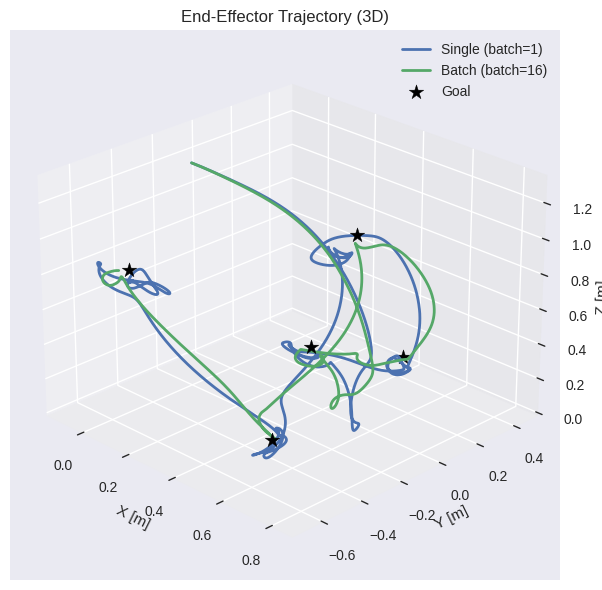

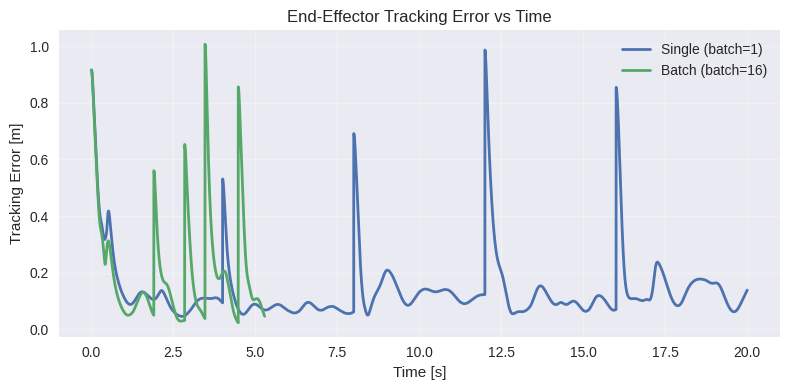

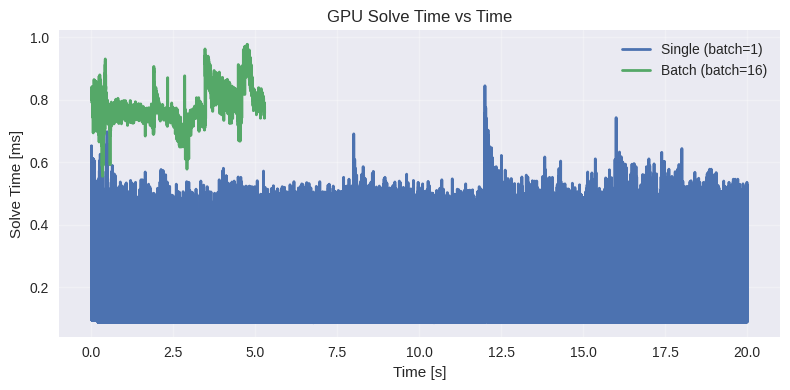

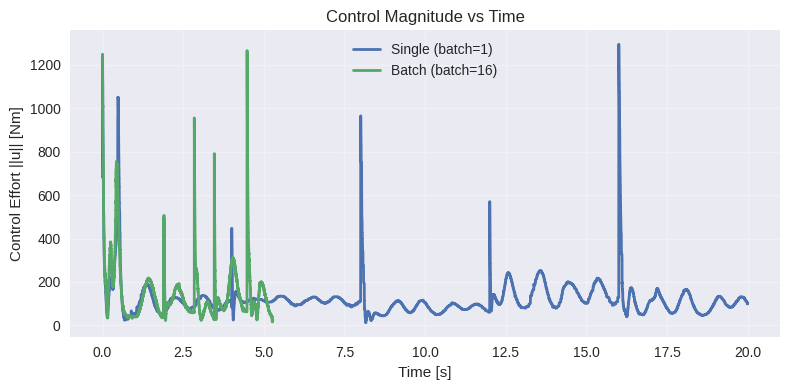

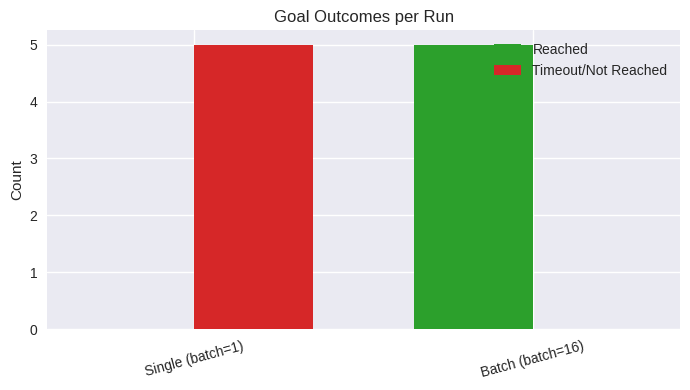

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

plt.style.use('seaborn-v0_8')

# Collect available results
results = []
if 'mpc_1' in globals() and 'mpc_stats_1' in globals() and isinstance(mpc_stats_1, dict):
    label_single = f"Single (batch={getattr(mpc_1, 'batch_size', 1)})"
    results.append({
        'label': label_single,
        'stats': mpc_stats_1
    })
if 'mpc_16' in globals() and 'mpc_stats_16' in globals() and isinstance(mpc_stats_16, dict):
    label_batch = f"Batch (batch={getattr(mpc_16, 'batch_size', 'N/A')})"
    results.append({
        'label': label_batch,
        'stats': mpc_stats_16
    })

if not results:
    raise RuntimeError('No experiment results found. Run the MPC cells first.')

# Helper functions

def to_2d(array_like):
    arr = np.asarray(array_like)
    if arr.ndim == 1:
        return arr[:, None]
    return arr

def stack_rows(list_of_arrays):
    if isinstance(list_of_arrays, np.ndarray) and list_of_arrays.dtype != object:
        return list_of_arrays
    return np.vstack([np.asarray(x) for x in list_of_arrays])

# Optional: toggle saving figures
save_figs = False
fig_suffix = ''  # e.g., '_exp1'

# 1) 3D End-Effector Trajectory with Goals
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for res in results:
    stats = res['stats']
    ee_actual = np.asarray(stats['ee_actual'])  # (T, 3)
    ax.plot(ee_actual[:, 0], ee_actual[:, 1], ee_actual[:, 2], label=res['label'], linewidth=2)

# Plot goals
for i, goal in enumerate(goals):
    ax.scatter(goal[0], goal[1], goal[2], marker='*', s=120, c='k', label='Goal' if i == 0 else None)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('End-Effector Trajectory (3D)')
ax.legend(loc='best')
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
if save_figs:
    plt.savefig(f'ee_traj3d{fig_suffix}.png', dpi=300)
plt.show()

# 2) Tracking Error over Time
fig, ax = plt.subplots(figsize=(8, 4))
for res in results:
    stats = res['stats']
    t = np.asarray(stats['timestamps'])
    if 'goal_distances' in stats and len(stats['goal_distances']) == len(t):
        err = np.asarray(stats['goal_distances'])
    else:
        # Fallback: compute from ee_actual and ee_goal
        ee_actual = np.asarray(stats['ee_actual'])
        ee_goal = np.asarray(stats['ee_goal'])
        err = np.linalg.norm(ee_actual[:, :3] - ee_goal[:, :3], axis=1)
    ax.plot(t, err, label=res['label'], linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Tracking Error [m]')
ax.set_title('End-Effector Tracking Error vs Time')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
if save_figs:
    plt.savefig(f'tracking_error{fig_suffix}.png', dpi=300)
plt.show()

# 3) Solver Time vs Time
fig, ax = plt.subplots(figsize=(8, 4))
for res in results:
    stats = res['stats']
    t = np.asarray(stats['timestamps'])
    solve_ms = np.asarray(stats['solve_times'])
    ax.plot(t, solve_ms, label=res['label'], linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Solve Time [ms]')
ax.set_title('GPU Solve Time vs Time')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
if save_figs:
    plt.savefig(f'solve_time{fig_suffix}.png', dpi=300)
plt.show()

# 4) Control Effort (||u||) vs Time
fig, ax = plt.subplots(figsize=(8, 4))
for res in results:
    stats = res['stats']
    t = np.asarray(stats['timestamps'])
    controls = stack_rows(stats['controls'])  # (T, nu)
    control_norm = np.linalg.norm(controls, axis=1)
    ax.plot(t, control_norm, label=res['label'], linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Control Effort ||u|| [Nm]')
ax.set_title('Control Magnitude vs Time')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
if save_figs:
    plt.savefig(f'control_norm{fig_suffix}.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
run_labels = []
reached_counts = []
timeout_counts = []
for res in results:
    stats = res['stats']
    outcomes = list(stats.get('goal_outcomes_by_idx', []))
    run_labels.append(res['label'])
    reached_counts.append(sum(1 for o in outcomes if o == 'reached'))
    timeout_counts.append(sum(1 for o in outcomes if o != 'reached'))

x = np.arange(len(run_labels))
width = 0.35
ax.bar(x - width/2, reached_counts, width, label='Reached', color='#2ca02c')
ax.bar(x + width/2, timeout_counts, width, label='Timeout/Not Reached', color='#d62728')
ax.set_xticks(x)
ax.set_xticklabels(run_labels, rotation=15)
ax.set_ylabel('Count')
ax.set_title('Goal Outcomes per Run')
ax.legend(loc='best')
plt.tight_layout()
if save_figs:
    plt.savefig(f'goal_outcomes{fig_suffix}.png', dpi=300)
plt.show()


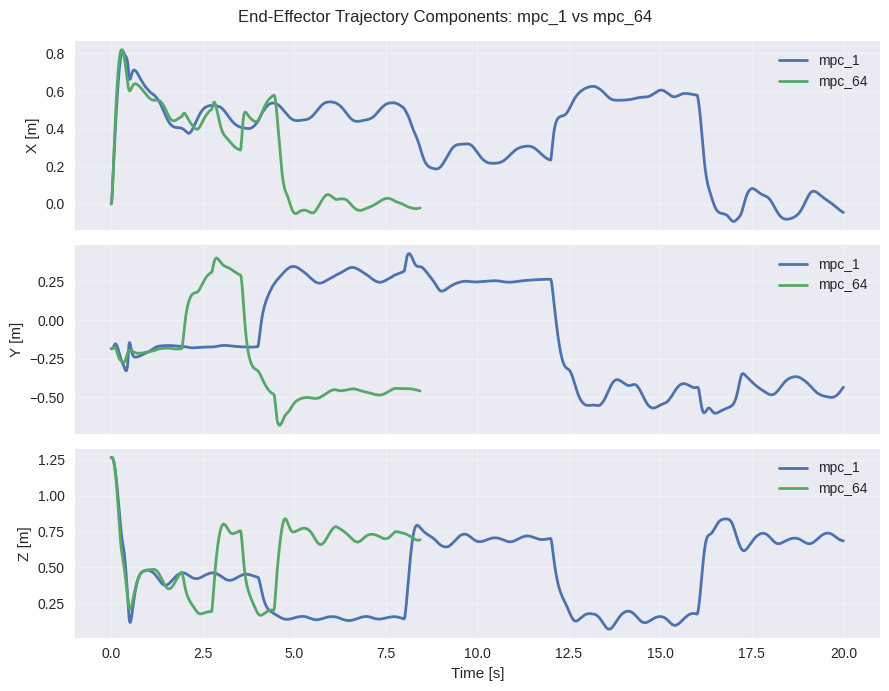

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Compare mpc_1 vs mpc_64 end-effector components (X, Y, Z)
if 'mpc_stats_1' not in globals() or 'mpc_stats_64' not in globals():
    raise RuntimeError('mpc_stats_1 and/or mpc_stats_64 not found. Run the MPC cells first.')

# Extract time and EE positions
t1 = np.asarray(mpc_stats_1['timestamps'])
ee1 = np.asarray(mpc_stats_1['ee_actual'])  # (T1, 3)

t64 = np.asarray(mpc_stats_64['timestamps'])
ee64 = np.asarray(mpc_stats_64['ee_actual'])  # (T64, 3)

fig, axs = plt.subplots(3, 1, figsize=(9, 7), sharex=True)

axs[0].plot(t1, ee1[:, 0], label='mpc_1', linewidth=2)
axs[0].plot(t64, ee64[:, 0], label='mpc_64', linewidth=2)
axs[0].set_ylabel('X [m]')
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc='best')

axs[1].plot(t1, ee1[:, 1], label='mpc_1', linewidth=2)
axs[1].plot(t64, ee64[:, 1], label='mpc_64', linewidth=2)
axs[1].set_ylabel('Y [m]')
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='best')

axs[2].plot(t1, ee1[:, 2], label='mpc_1', linewidth=2)
axs[2].plot(t64, ee64[:, 2], label='mpc_64', linewidth=2)
axs[2].set_ylabel('Z [m]')
axs[2].set_xlabel('Time [s]')
axs[2].grid(True, alpha=0.3)
axs[2].legend(loc='best')

fig.suptitle('End-Effector Trajectory Components: mpc_1 vs mpc_64', y=0.98)
plt.tight_layout()
plt.show()


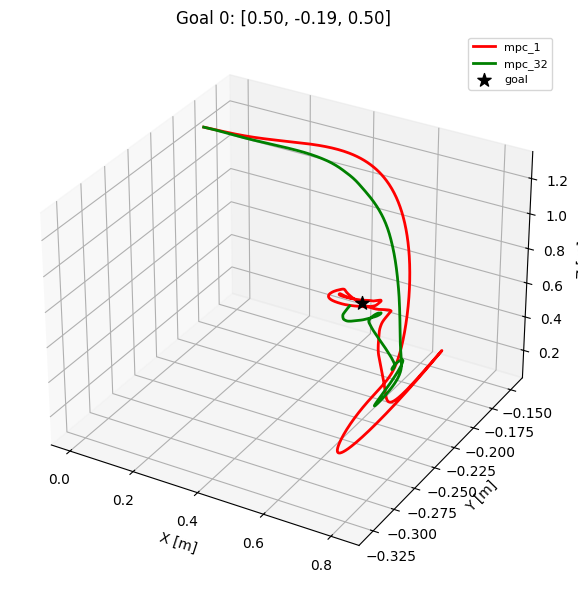

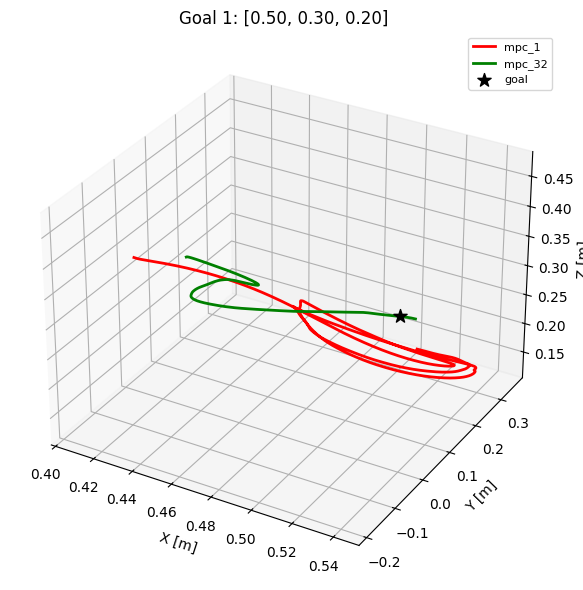

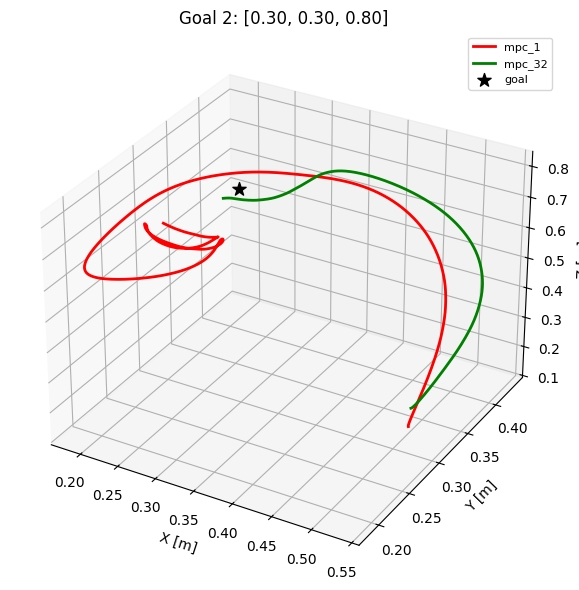

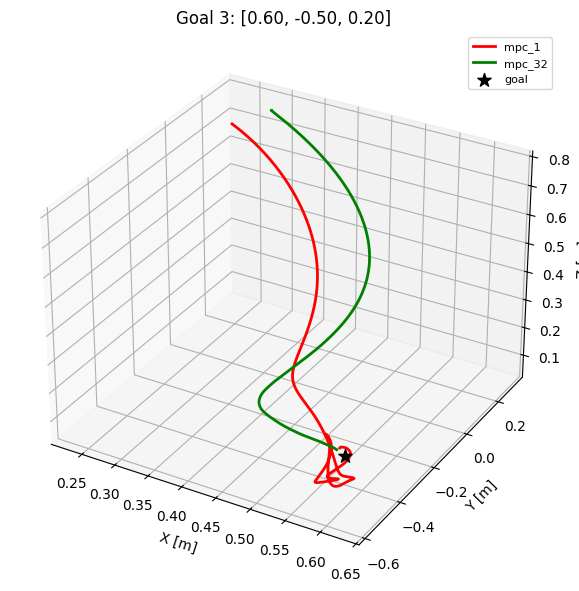

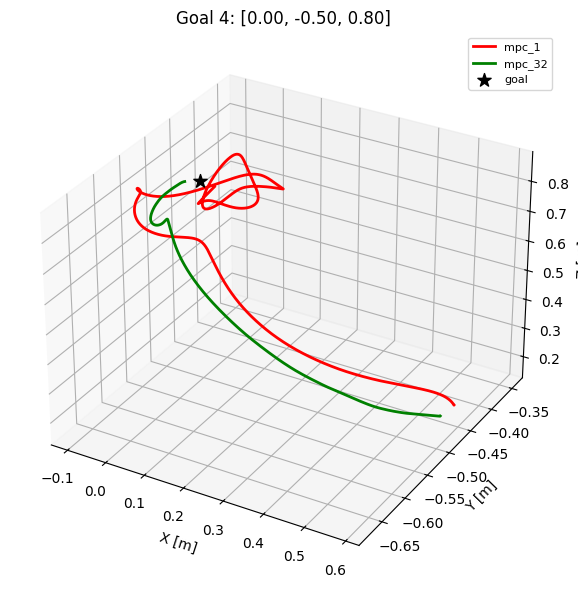

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

if 'mpc_stats_1' not in globals() or 'mpc_stats_32' not in globals():
    raise RuntimeError('mpc_stats_1 and/or mpc_stats_32 not found. Run the MPC cells first.')


def segments_from_stats(stats):
    ee_goal = np.asarray(stats['ee_goal'])  # (T, 3)
    T = ee_goal.shape[0]
    if T == 0:
        return []
    change_idxs = [0]
    for i in range(1, T):
        if not np.allclose(ee_goal[i], ee_goal[i - 1], atol=1e-9):
            change_idxs.append(i)
    change_idxs.append(T)
    segments = []
    for s, e in zip(change_idxs[:-1], change_idxs[1:]):
        segments.append({'start': s, 'end': e, 'goal': ee_goal[s]})
    return segments


seg1 = segments_from_stats(mpc_stats_1)
seg32 = segments_from_stats(mpc_stats_32)

num_goals = max(len(seg1), len(seg32))
if num_goals == 0:
    raise RuntimeError('No goal segments detected in stats.')

# Prepare data arrays
EE1 = np.asarray(mpc_stats_1['ee_actual'])  # (T1, 3)
EE32 = np.asarray(mpc_stats_32['ee_actual'])  # (T32, 3)

# Plot each goal segment individually
for i in range(num_goals):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot mpc_1 segment
    if i < len(seg1):
        s, e = seg1[i]['start'], seg1[i]['end']
        traj = EE1[s:e]
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='mpc_1', linewidth=2, color='red')
        goal_pt_1 = seg1[i]['goal']
    else:
        goal_pt_1 = None

    # Plot mpc_32 segment
    if i < len(seg32):
        s2, e2 = seg32[i]['start'], seg32[i]['end']
        traj2 = EE32[s2:e2]
        ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], label='mpc_32', linewidth=2, color='green')
        goal_pt_32 = seg32[i]['goal']
    else:
        goal_pt_32 = None

    goal_pt = goal_pt_1 if goal_pt_1 is not None else goal_pt_32
    if goal_pt is not None:
        ax.scatter(goal_pt[0], goal_pt[1], goal_pt[2], marker='*', s=100, c='k', label='goal')
        ax.set_title(f'Goal {i}: [{goal_pt[0]:.2f}, {goal_pt[1]:.2f}, {goal_pt[2]:.2f}]')
    else:
        ax.set_title(f'Goal {i}')

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.legend(loc='best', fontsize=8)
    
    plt.tight_layout()
    plt.show()


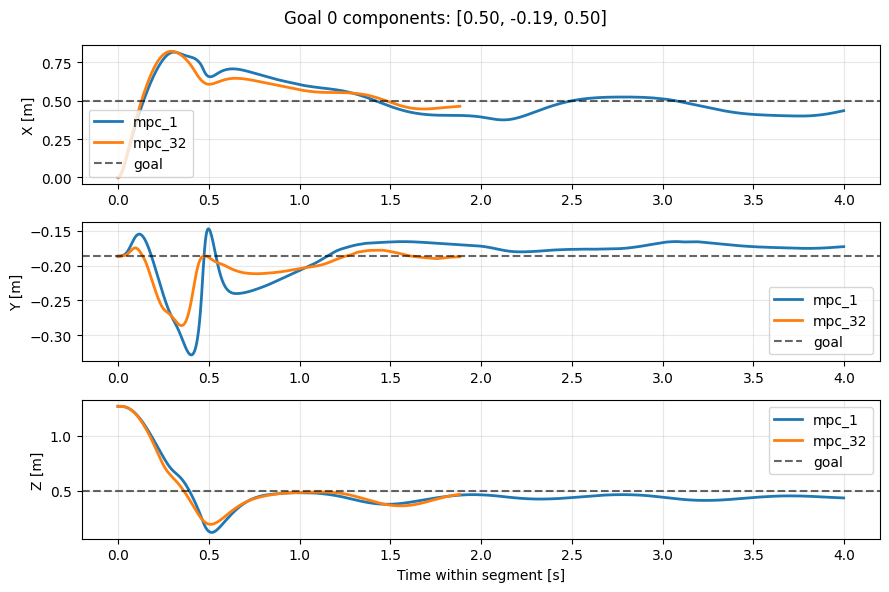

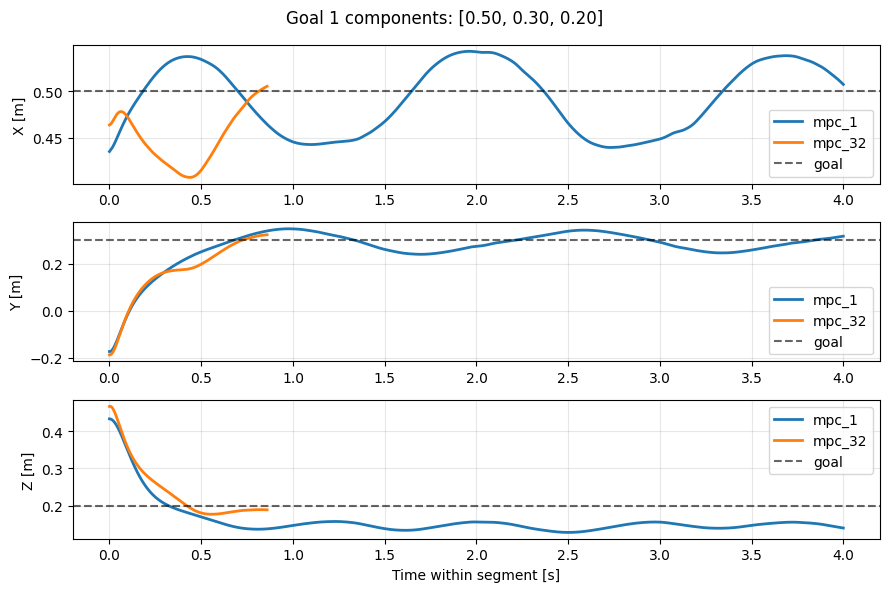

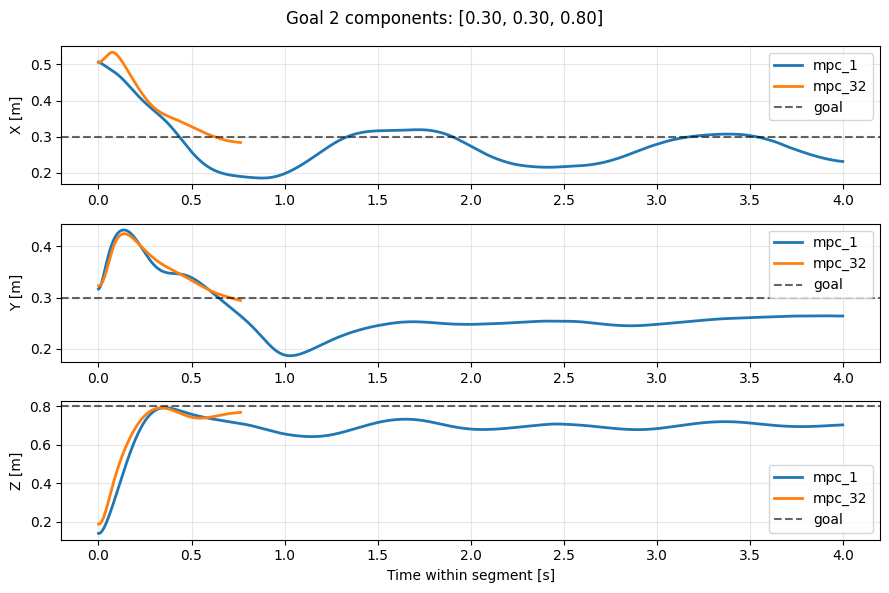

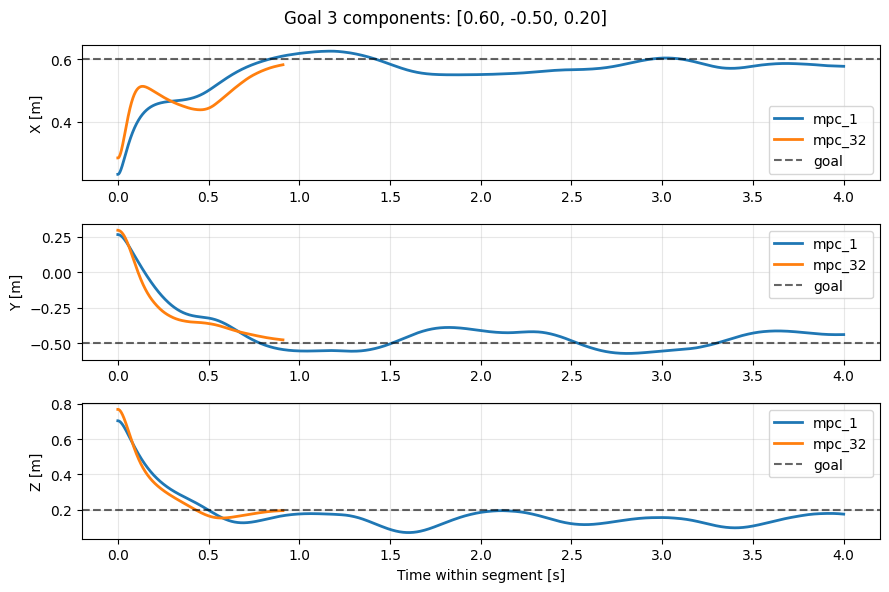

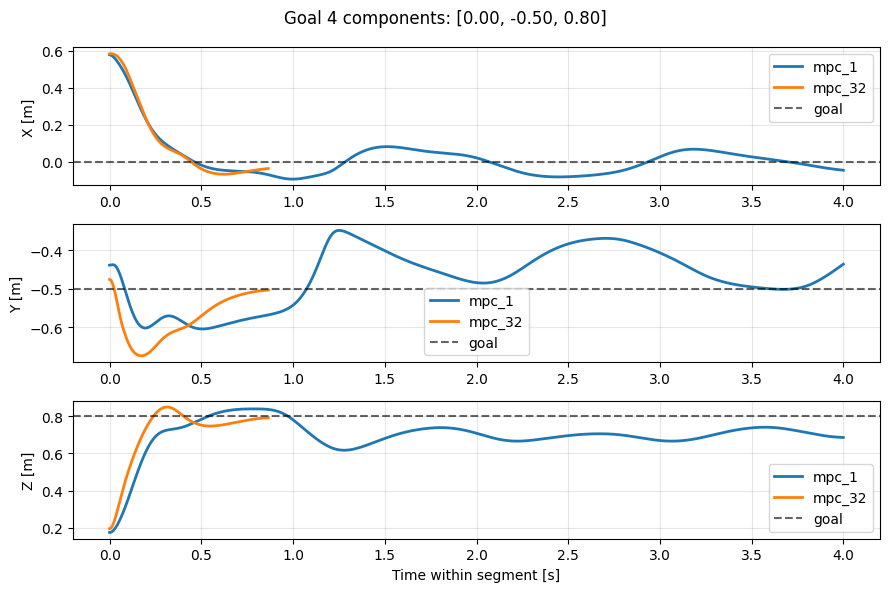

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Plot X, Y, Z components separately for each goal segment, overlaying mpc_1 and mpc_32
if 'mpc_stats_1' not in globals() or 'mpc_stats_32' not in globals():
    raise RuntimeError('mpc_stats_1 and/or mpc_stats_32 not found. Run the MPC cells first.')


def goal_segments(stats):
    ee_goal = np.asarray(stats['ee_goal'])
    T = len(ee_goal)
    if T == 0:
        return []
    change_idxs = [0]
    for i in range(1, T):
        if not np.allclose(ee_goal[i], ee_goal[i - 1], atol=1e-9):
            change_idxs.append(i)
    change_idxs.append(T)
    return [{'start': s, 'end': e, 'goal': ee_goal[s]} for s, e in zip(change_idxs[:-1], change_idxs[1:])]


seg1 = goal_segments(mpc_stats_1)
seg32 = goal_segments(mpc_stats_32)
num_goals = max(len(seg1), len(seg32))
if num_goals == 0:
    raise RuntimeError('No goal segments detected.')

# Full arrays
T1 = np.asarray(mpc_stats_1['timestamps'])
EE1 = np.asarray(mpc_stats_1['ee_actual'])
T32 = np.asarray(mpc_stats_32['timestamps'])
EE32 = np.asarray(mpc_stats_32['ee_actual'])

for gi in range(num_goals):
    fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=False)

    goal_pt = None

    # mpc_1 segment
    if gi < len(seg1):
        s, e = seg1[gi]['start'], seg1[gi]['end']
        t_rel = T1[s:e] - T1[s]
        axs[0].plot(t_rel, EE1[s:e, 0], label='mpc_1', linewidth=2)
        axs[1].plot(t_rel, EE1[s:e, 1], label='mpc_1', linewidth=2)
        axs[2].plot(t_rel, EE1[s:e, 2], label='mpc_1', linewidth=2)
        goal_pt = seg1[gi]['goal']

    # mpc_32 segment
    if gi < len(seg32):
        s2, e2 = seg32[gi]['start'], seg32[gi]['end']
        t_rel2 = T32[s2:e2] - T32[s2]
        axs[0].plot(t_rel2, EE32[s2:e2, 0], label='mpc_32', linewidth=2)
        axs[1].plot(t_rel2, EE32[s2:e2, 1], label='mpc_32', linewidth=2)
        axs[2].plot(t_rel2, EE32[s2:e2, 2], label='mpc_32', linewidth=2)
        if goal_pt is None:
            goal_pt = seg32[gi]['goal']

    if goal_pt is not None:
        axs[0].axhline(goal_pt[0], linestyle='--', color='k', alpha=0.6, label='goal')
        axs[1].axhline(goal_pt[1], linestyle='--', color='k', alpha=0.6, label='goal')
        axs[2].axhline(goal_pt[2], linestyle='--', color='k', alpha=0.6, label='goal')

    axs[0].set_ylabel('X [m]')
    axs[1].set_ylabel('Y [m]')
    axs[2].set_ylabel('Z [m]')
    axs[2].set_xlabel('Time within segment [s]')

    for ax in axs:
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')

    if goal_pt is not None:
        fig.suptitle(f'Goal {gi} components: [{goal_pt[0]:.2f}, {goal_pt[1]:.2f}, {goal_pt[2]:.2f}]', y=0.98)
    else:
        fig.suptitle(f'Goal {gi} components', y=0.98)

    plt.tight_layout()
    plt.show()
